In [1]:
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
import torch
import torch.nn as nn
import torchvision
from torchvision import transforms, datasets
from torch.utils.data.dataset import *
from PIL import Image
from torch.nn import functional as F
import random
import os
import sys

In [2]:
# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [4]:
print(device)

cpu


In [7]:
# Hyper-parameters 
# input_size = 784
hidden_size = 500
num_classes = 4
num_epochs = 2
batch_size = 64
learning_rate = 0.001

data_transform = transforms.Compose([
        transforms.Resize((200,200)),
#         transforms.RandomSizedCrop(180),
        transforms.RandomResizedCrop(180, (0.8, 1)),

        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406],
                             std=[0.229, 0.224, 0.225])
    ])
train_dataset = datasets.ImageFolder(root='data/aaa/train',
                                           transform=data_transform)

test_dataset = datasets.ImageFolder(root='data/aaa/test',
                                           transform=data_transform)
# Data loader
train_loader = torch.utils.data.DataLoader(dataset=train_dataset,
                                           batch_size=batch_size,
                                           shuffle=True)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset,
                                          batch_size=batch_size,
                                          shuffle=False)

In [8]:
# # Fully connected neural network with one hidden layer
# class NeuralNet_1(nn.Module):
#     def __init__(self, input_size, hidden_size, num_classes):
#         super(NeuralNet_1, self).__init__()
#         self.fc1 = nn.Linear(input_size, 500)
#         self.relu = nn.ReLU()
#         self.fc2 = nn.Linear(500, num_classes)

#     def forward(self, x):
#         out = self.fc1(x)
#         out = self.relu(out)#relu
#         out = self.fc2(out)
#         return out
# Convolutional neural network (two convolutional layers)
class ConvNet_1(nn.Module):
    def __init__(self, num_classes=5):
        super(ConvNet_1, self).__init__()
        self.layer1 = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=2),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2))
        self.layer2 = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=2),
            #nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2))
        self.layer3 = nn.Sequential(
            nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=2),
            #nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2))
        self.layer4 = nn.Sequential(
            nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=2),
            #nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2))
        self.layer5 = nn.Sequential(
            nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=2),
            #nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2))
        self.fc1 = nn.Linear(6272, 200)
        self.fc2 = nn.Linear(200, num_classes)

    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = self.layer5(out)
        out = out.reshape(out.size(0), -1)
        out = self.fc1(out)
        out = self.fc2(out)
        return out
model = ConvNet_1(num_classes).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [12]:
# --coding:utf-8--
 
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy
from tensorboardX import SummaryWriter
model_ft = models.vgg16(pretrained=True)
# 冻结卷积层
for name, par in model_ft.named_parameters():
    if 'features' in name:
        par.requires_grad = False

#修改几层
model_ft.classifier[6] = nn.Linear(4096, 5)
model_ft = model_ft.to(device)
# Decay LR by a factor of 0.1 every 7 epochs
optimizer_ft = optim.SGD(lr=learning_rate, params=filter(lambda p: p.requires_grad, model_ft.parameters()))

In [13]:
model = torchvision.models.resnet18(pretrained=True)
#print(model)

#将卷积部分冻结
for param in model.parameters():
    #将卷积层部分的参数冻结
    param.requires_grad = False

#model.fc.会返回仅有一个的线性层
#继承原有线性层的输入特征数
in_f = model.fc.in_features
#自己构造线性层并替换原来线性层
model.fc = nn.Linear(in_f,5)
#只需要优化最后的Linear层参数
optimizer = torch.optim.Adam(model.fc.parameters(),lr=0.001)
#对学习速率进行衰减
exp_lr_schedule = lr_scheduler.StepLR(optimizer,step_size=5,gamma=0.1)
epochs = 2
loss_fn = nn.CrossEntropyLoss()
model = model.to(device)

def fit(epoch,model,trainloader,testloder):
    #下面三个是个数不是概率
    correct = 0
    total = 0
    running_loss = 0
    #Dropput在训练的时候回随机丢弃神经元(的输出),但预测的时候不会
    #model.train()是训练模式,想让Dropout发挥作用,对BN层也有用
    model.train()
    for x,y in trainloader:
        #将训练数据也放到GPU上
        x = x.to(device)
        y = y.to(device)
        y_pred = model(x)
        loss = loss_fn(y_pred, y)
        # 梯度置为0
        optimizer.zero_grad()
        # 反向传播求解梯度
        loss.backward()
        # 优化
        optimizer.step()
        # 不需要进行梯度计算
        with torch.no_grad():
            #torch.argmax将数字转换成真正的预测结果
            y_pred = torch.argmax(y_pred, dim=1)
            #计算个数
            correct += (y_pred == y).sum().item()
            total += y.size(0)
            running_loss += loss.item()

    #一旦exp_lr_schedule.step()运行了5次就调整学习速率
    exp_lr_schedule.step()
    #除以的是总样本数 trainloader.dataset是形参,实参是train_dl即train_dl.dataset
    #train_dl.dataset指向的是train_ds
    epoch_loss = running_loss/len(trainloader.dataset)
    epoch_acc = correct/total


In [14]:
model_1= ConvNet_1( num_classes).to(device)
model_2= model_ft
model_3= model
# model_3= NeuralNet_3(input_size, hidden_size, num_classes).to(device)
# model_4= NeuralNet_4(input_size, hidden_size, num_classes).to(device)

In [15]:
from sklearn.metrics import f1_score,precision_score,recall_score,accuracy_score
import numpy as np
def get_score(y_true, y_pred):

        accuracy=accuracy_score(y_true, y_pred)
        precision=precision_score(y_true, y_pred, average='macro')
        recall=recall_score(y_true, y_pred, average='macro')
        f1score=f1_score(y_true, y_pred,average='macro')
        return accuracy,precision,recall,f1score
# Train the model
score_all=[]
total_step = len(train_loader)
for model in [model_1,model_2,model_3]:
# for model in [model_1]:
    score_iter=[]

    #model = NeuralNet(input_size, hidden_size, num_classes).to(device)
    # Loss and optimizer
    criterion = nn.CrossEntropyLoss()#LOSS FUNCTION , MSE
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    for epoch in range(num_epochs):
        for i, (images, labels) in enumerate(train_loader):
            # Move tensors to the configured device
            images = images.to(device)
            labels = labels.to(device)

            # Forward pass
            outputs = model(images)
            loss = criterion(outputs, labels)
            #Get accuracy
            _, predicted = torch.max(outputs.data, 1)
            # Backward and optimize
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            if (i + 1) % 100 == 0:
                print('Epoch [{}/{}], Step [{}/{}], loss: {}'
                    .format(epoch + 1, num_epochs, i + 1, total_step, loss.item()))
            if (i + 1) % 10 == 0:
                with torch.no_grad():
                    labels_all = []
                    predicted_all = []
                    for images, labels in test_loader:
                        images = images.to(device)
                        labels = labels.to(device)
                        outputs = model(images)
                        _, predicted = torch.max(outputs.data, 1)
                        labels=labels.cpu().numpy().flatten().tolist()
                        predicted=predicted.cpu().numpy().flatten().tolist()
                        labels_all=labels_all+labels
                        predicted_all=predicted_all+predicted
                    labels_all=np.array(labels_all).flatten()
                    predicted_all=np.array(predicted_all).flatten()
                    y_true=labels_all
                    y_pred=predicted_all
                    accuracy,precision,recall,f1score=get_score(y_true, y_pred)
                    score_iter.append([loss.item(),accuracy,precision,recall,f1score])
    score_all.append(score_iter)

Epoch [1/2], Step [100/147], loss: 0.5266616940498352
Epoch [2/2], Step [100/147], loss: 0.3670238256454468
Epoch [1/2], Step [100/147], loss: 0.36107081174850464
Epoch [2/2], Step [100/147], loss: 0.2046668529510498
Epoch [1/2], Step [100/147], loss: 0.3005894720554352
Epoch [2/2], Step [100/147], loss: 0.1785304844379425


In [16]:
score_all_array=np.array(score_all)
print(score_all_array.shape)
np.save("score_all_array_for_testDataSet",score_all_array)# (4, 230, 5) 4 learning-rate value *   iterate * 5 metrice

(3, 28, 5)


In [18]:
# score_all_array1=score_all_array.transpose(2,2,1)
score_all_array1=score_all_array.transpose(2,0,1)
print(score_all_array1.shape)

(5, 3, 28)


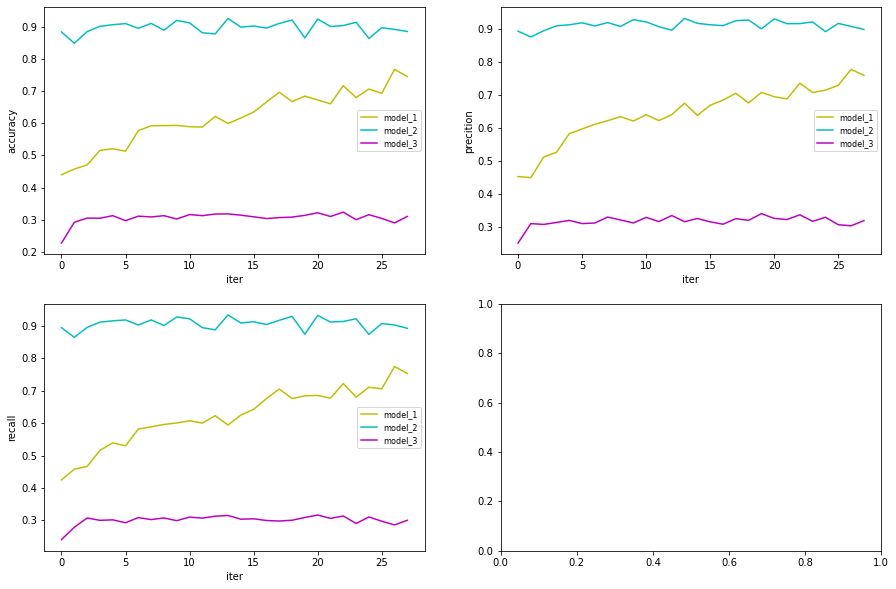

In [19]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

fig, axs = plt.subplots(2 ,2 ,figsize = (15, 10))
plot_array=score_all_array1[1]
axs[0][0].plot(plot_array.T[:,0],'y',label='model_1')
axs[0][0].plot(plot_array.T[:,1],'c',label='model_2')
axs[0][0].plot(plot_array.T[:,2],'m',label='model_3')
# axs[0][0].plot(plot_array.T[:,3],'k',label='model_4')
axs[0][0].set_xlabel('iter')
axs[0][0].set_ylabel('accuracy')
#axs[0].grid(True)
axs[0][0].legend(fontsize=8)

plot_array=score_all_array1[2]
axs[0][1].plot(plot_array.T[:,0],'y',label='model_1')
axs[0][1].plot(plot_array.T[:,1],'c',label='model_2')
axs[0][1].plot(plot_array.T[:,2],'m',label='model_3')
# axs[0][1].plot(plot_array.T[:,3],'k',label='model_4')
axs[0][1].set_xlabel('iter')
axs[0][1].set_ylabel('precition')
#axs[0].grid(True)
axs[0][1].legend(fontsize=8)

plot_array=score_all_array1[3]
axs[1][0].plot(plot_array.T[:,0],'y',label='model_1')
axs[1][0].plot(plot_array.T[:,1],'c',label='model_2')
axs[1][0].plot(plot_array.T[:,2],'m',label='model_3')
# axs[1][0].plot(plot_array.T[:,3],'k',label='model_4')
axs[1][0].set_xlabel('iter')
axs[1][0].set_ylabel('recall')
#axs[0].grid(True)
axs[1][0].legend(fontsize=8)

# plot_array=score_all_array1[4]
# axs[1][1].plot(plot_array.T[:,0],'y',label='model_1')
# axs[1][1].plot(plot_array.T[:,1],'c',label='model_2')
# axs[1][1].plot(plot_array.T[:,2],'m',label='model_3')
# axs[1][1].plot(plot_array.T[:,3],'k',label='model_4')
# axs[1][1].set_xlabel('iter')
# axs[1][1].set_ylabel('f1 score')
# #axs[0].grid(True)
# axs[1][1].legend(fontsize=8)



plt.show()

In [15]:
plt.savefig("Mnist_compare_4_model.pdf",dpi=300)

<Figure size 432x288 with 0 Axes>

In [35]:
score_all_array2=score_all_array[:,210:,:]
print(score_all_array2.shape)

(4, 20, 5)


In [36]:
def print_s(mean,std):
    print("{:.2f}+{:.2f}  {:.2f}+{:.2f}  {:.2f}+{:.2f}  {:.2f}+{:.2f}".format(mean[1],std[1],mean[2],std[2],mean[3],std[3],mean[4],std[4]))

result=score_all_array2[0]
mean = np.mean(result,0)*100
std=np.std(result,0)*100
print_s(mean,std)

result=score_all_array2[1]
mean = np.mean(result,0)*100
std=np.std(result,0)*100
print_s(mean,std)

result=score_all_array2[2]
mean = np.mean(result,0)*100
std=np.std(result,0)*100
print_s(mean,std)

result=score_all_array2[3]
mean = np.mean(result,0)*100
std=np.std(result,0)*100
print_s(mean,std)
                                                                              

98.07+0.06  98.07+0.06  98.05+0.07  98.06+0.06
98.10+0.07  98.10+0.07  98.09+0.07  98.09+0.07
97.88+0.17  97.88+0.16  97.86+0.16  97.86+0.17
97.03+0.16  97.01+0.16  97.00+0.16  97.00+0.16
